In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
plt.style.use('science')

In [2]:
import lib.python.lib_FHRR_Loihi as lib
import lib.python.utility as util
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

In [3]:
def plot_multiple_box_plots(data_sets, x_title="X Values", y_title="Y Values", title="", show_box_plots=True, label_prefix="", y_limits=None, x_limits=None, figsize=(10, 6), show_outliers=False, rotate_xticks=False, xtick_fontsize=8):
    """
    Plots multiple sets of customized black and white box plots for each x value with multiple y values,
    indicates outliers, and adds a line graph connecting the means of y values for each dataset.

    Parameters:
    data_sets (list of dicts): List of dictionaries, each containing 'x_values', 'y_values', and 'title' keys.
                               Each dictionary represents a dataset.
    x_title (str): Label for the x-axis.
    y_title (str): Label for the y-axis.
    title (str): Overall title of the plot.
    show_box_plots (bool): If True, display box plots. If False, only plot the means.
    y_limits (tuple): Optional parameter to set the y-axis limits. Should be a tuple (y_min, y_max).
    """
    fig, ax = plt.subplots(figsize=figsize)

    plt.rcParams["figure.figsize"] = [7.00, 7.50]
    plt.rcParams["figure.autolayout"] = True

    colors = ['black', 'blue', 'green', 'red', 'purple', 'orange'] 

    for idx, data_set in enumerate(data_sets):
        x_values = data_set['x_values']
        y_values = data_set['y_values']
        dataset_title = data_set.get('title', f'Dataset {idx + 1}')
        color = colors[idx % len(colors)]
        
        if show_box_plots:
            # Create the box plot
            boxplot = ax.boxplot(y_values, positions=x_values, patch_artist=False, showmeans=True, meanline=True,
                                 showfliers=show_outliers,
                                 flierprops=dict(marker='x', color=color, markersize=5), boxprops=dict(color=color),
                                 whiskerprops=dict(color=color), capprops=dict(color=color), medianprops=dict(color=color))
        
        # Calculate means of y values
        means = [np.mean(y) for y in y_values]
        
        # Plot the line graph connecting the means
        label_txt = label_prefix + f' {dataset_title}'
        ax.plot(x_values, means, color=color, linestyle='-', marker='o', markerfacecolor='none', label=label_txt)

    # Set the x-axis labels with optional rotation
    ax.set_xticks(x_values)
    ax.set_xticklabels([str(x) for x in x_values], rotation=45 if rotate_xticks else 0, fontsize=xtick_fontsize)

    # Set labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)

    if x_limits is not None:
        ax.set_xlim(x_limits)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()


## Experiment 1: HD Reconstruction - Similarity for varying dimension for differnet simulation times

In [4]:

dimension_list = [10, 50, 100, 200, 500, 1000]
sim_time_list = [50, 75, 100, 150, 200]


In [5]:
sim_time   = 1000
rv_repeat = 1

full_rslt = []

for sim_time in tqdm(sim_time_list):
    sim_rslt = []
    for dimensions in tqdm(dimension_list):
        rv_rslt = []
        for _ in range(rv_repeat):
            rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
            
            error_percentage = 0.0498 # To make v_th=120 for a nice figure
            # 0.06283 = 2 pi * 1%
            # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
            lib.set_params_manual(120, 0.06283)
            
            encoder  = lib.FHRR_Encoder(vec = rv1)
            decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
            
            encoder.spikes_out.connect(decoder.spikes_a_in)
            
            decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
            
            raw_rslt  = decoder.get_decoded_value()
            
            decoder.stop()
        
            rslt = cosine_similarity([rv1], [raw_rslt])[0][0]
            # print(rslt)
        
            rv_rslt.append(rslt)
            
        sim_rslt.append(rv_rslt)
    full_rslt.append( {'title':sim_time, 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [02:00<00:00, 24.08s/it]


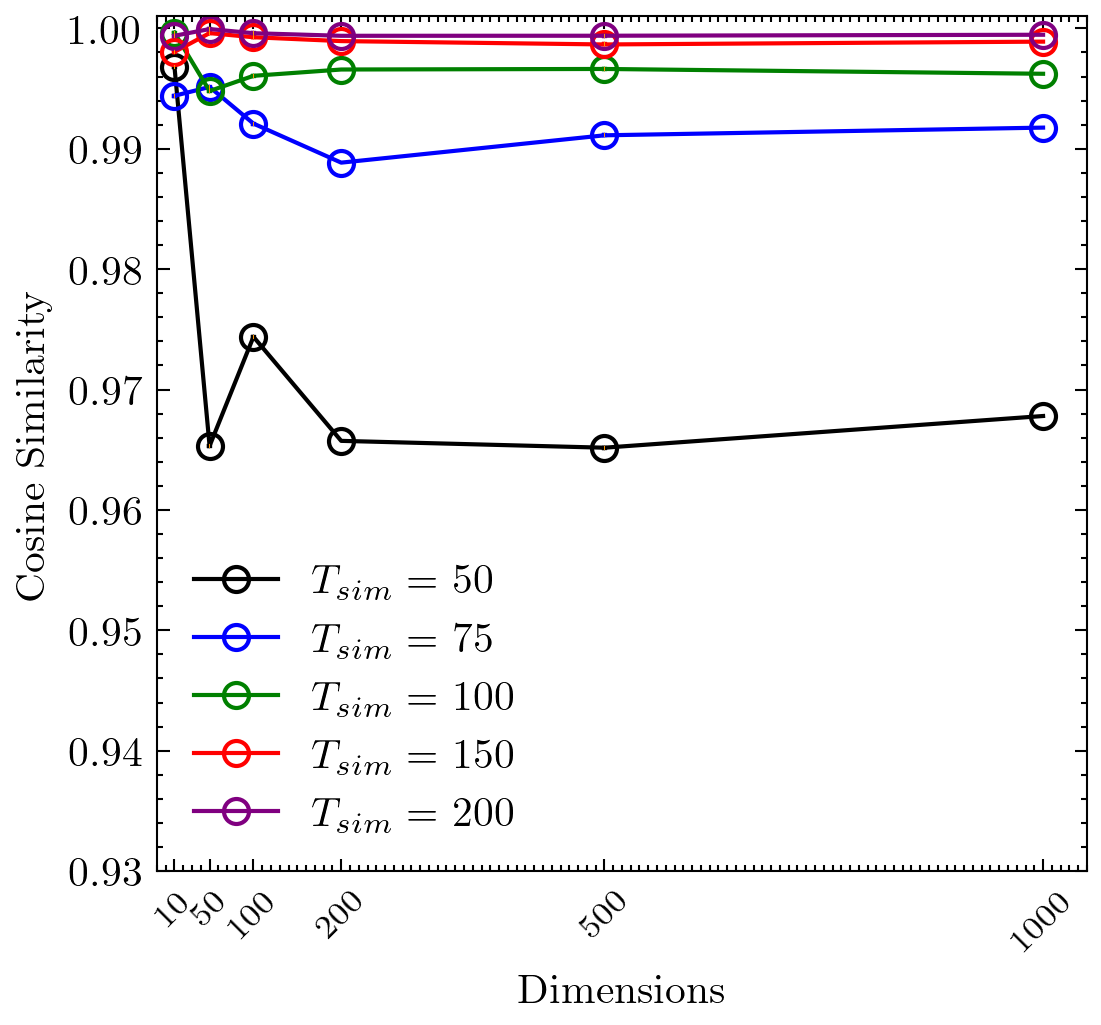

In [6]:
plot_multiple_box_plots(full_rslt, "Dimensions", "Cosine Similarity", "", True, label_prefix="$T_{sim} = $", x_limits=(-10,1050), figsize=(4,3.7), y_limits=(0.93, 1.001), rotate_xticks=True)

## Experiment 2: HD Reconstruction - Similarity for varying dimension for differnet V_th

In [7]:
dimension_list = [10, 50, 100, 200, 500, 1000]
vth_list = [5, 10, 20, 50, 100]


In [8]:
sim_time   = 200
rv_repeat = 1

full_rslt_vth = []

for v_th in tqdm(vth_list):
    sim_rslt = []
    for dimensions in tqdm(dimension_list):
        rv_rslt = []
        for _ in range(rv_repeat):
            rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
            
            error_percentage = 0.0498 # To make v_th=120 for a nice figure
            # 0.06283 = 2 pi * 1%
            # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
            lib.set_params_manual(v_th, sim_time)
            
            encoder  = lib.FHRR_Encoder(vec = rv1)
            decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
            
            encoder.spikes_out.connect(decoder.spikes_a_in)
            
            decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
            
            raw_rslt  = decoder.get_decoded_value()
            
            decoder.stop()
        
            rslt = cosine_similarity([rv1], [raw_rslt])[0][0]
            # print(rslt)
        
            rv_rslt.append(rslt)
            
        sim_rslt.append(rv_rslt)
    full_rslt_vth.append( {'title':v_th, 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [01:22<00:00, 16.48s/it]


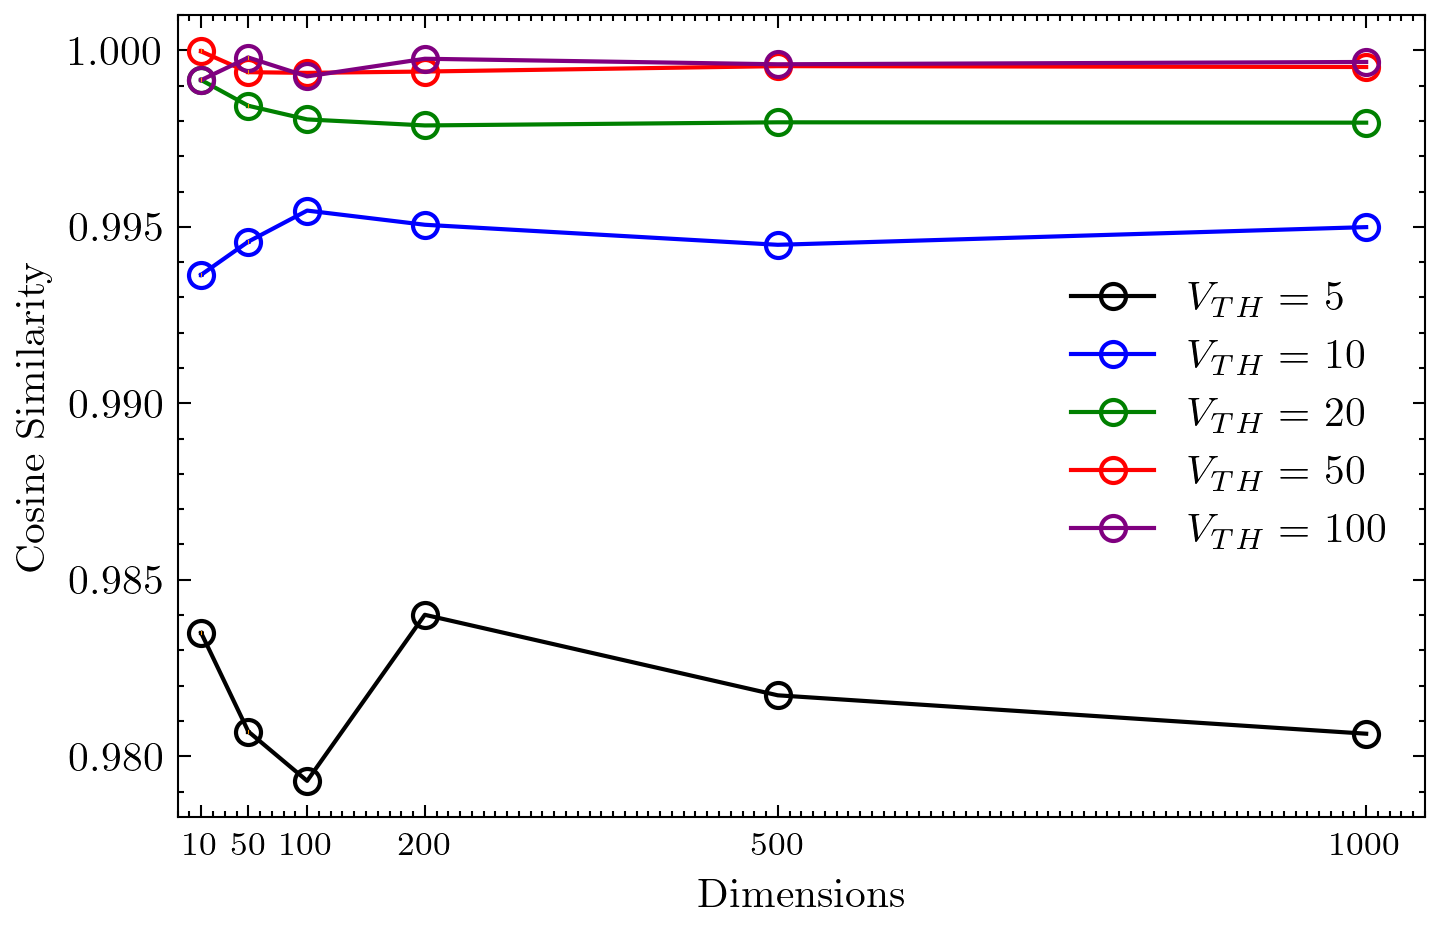

In [9]:
plot_multiple_box_plots(full_rslt_vth, "Dimensions", "Cosine Similarity", "", True, label_prefix="$V_{TH} = $", x_limits=(-10,1050), figsize=(5,3.3))#, y_limits=(0.9995, 1))